# Plots of the IRFs

This notebook recreats Fig. 2-5 of the paper, comparing the instrument response functions (IRFs) from CTA and KM3NeT.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

from astropy.io import fits
import astropy.units as u

from gammapy.irf import load_cta_irfs
from gammapy.irf import PSF3D, EnergyDispersion2D, Background2D, EffectiveAreaTable2D

from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.stats import binned_statistic

from glob import glob
import os
import sys
sys.path.append('../src')


from configure_analysis import AnalysisConfig
import plot_utils

analysisconfig = AnalysisConfig()

%matplotlib inline
plt.rcdefaults()

## KM3NeT

### Reading the IRFs from files

For the study, a dedicated Monte Carlo simulation of neutrino and muon events in KM3NeT was used to generate the IRFs. Plots in the publication were generated directly from the simulation, while here the plots are recreated from the IRF `.fits` files. This might lead to minor differences between the plots.

In [2]:
# Read effective area IRFs
aeff = EffectiveAreaTable2D.read(analysisconfig.get_file("km3net/irfs/aeff.fits"), hdu='EFFECTIVE AREA')
km3_e_binc = aeff.data.axes[0].center
km3_aeff = np.array(aeff.data.data)

#print the content of Effective area
print(aeff)

EffectiveAreaTable2D
NDDataArray summary info
MapAxis

	name       : energy_true
	unit       : 'GeV'     
	nbins      : 48        
	node type  : edges     
	edges min  : 1.0e+02 GeV
	edges max  : 1.0e+08 GeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'rad'     
	nbins      : 12        
	node type  : edges     
	edges min  : 0.0e+00 rad
	edges max  : 3.1e+00 rad
	interp     : lin       
Data           : size =   576, min =  0.000 m2, max = 9913.258 m2



## CTA

Reading the adjusted CTA IRF file containing all relevant functions.

In [4]:
cta_irfs = load_cta_irfs(analysisconfig.get_file("cta/irfs/irf_file_new_CTA.fits"))

In [5]:
cta_aeff = cta_irfs['aeff']
cta_aeff_e = cta_aeff.data.axes[0].center.value
cta_aeff_a = cta_aeff.data.evaluate(energy_true=cta_aeff.data.axes[0].center, offset=1*u.deg).value
print(cta_aeff)

EffectiveAreaTable2D
NDDataArray summary info
MapAxis

	name       : energy_true
	unit       : 'TeV'     
	nbins      : 42        
	node type  : edges     
	edges min  : 1.3e-02 TeV
	edges max  : 2.0e+02 TeV
	interp     : log       
MapAxis

	name       : offset    
	unit       : 'deg'     
	nbins      : 6         
	node type  : edges     
	edges min  : 0.0e+00 deg
	edges max  : 6.0e+00 deg
	interp     : lin       
Data           : size =   252, min =  0.000 m2, max = 3784889.250 m2



### Comparison of effective areas

The CTA effective area is shown for a zenith angle of θ = 20° and an offset angle from the pointing direction of θ = 1. For KM3NeT, effective areas for the full sky as well as for different zenith angle ranges are shown. (Fig. 3)

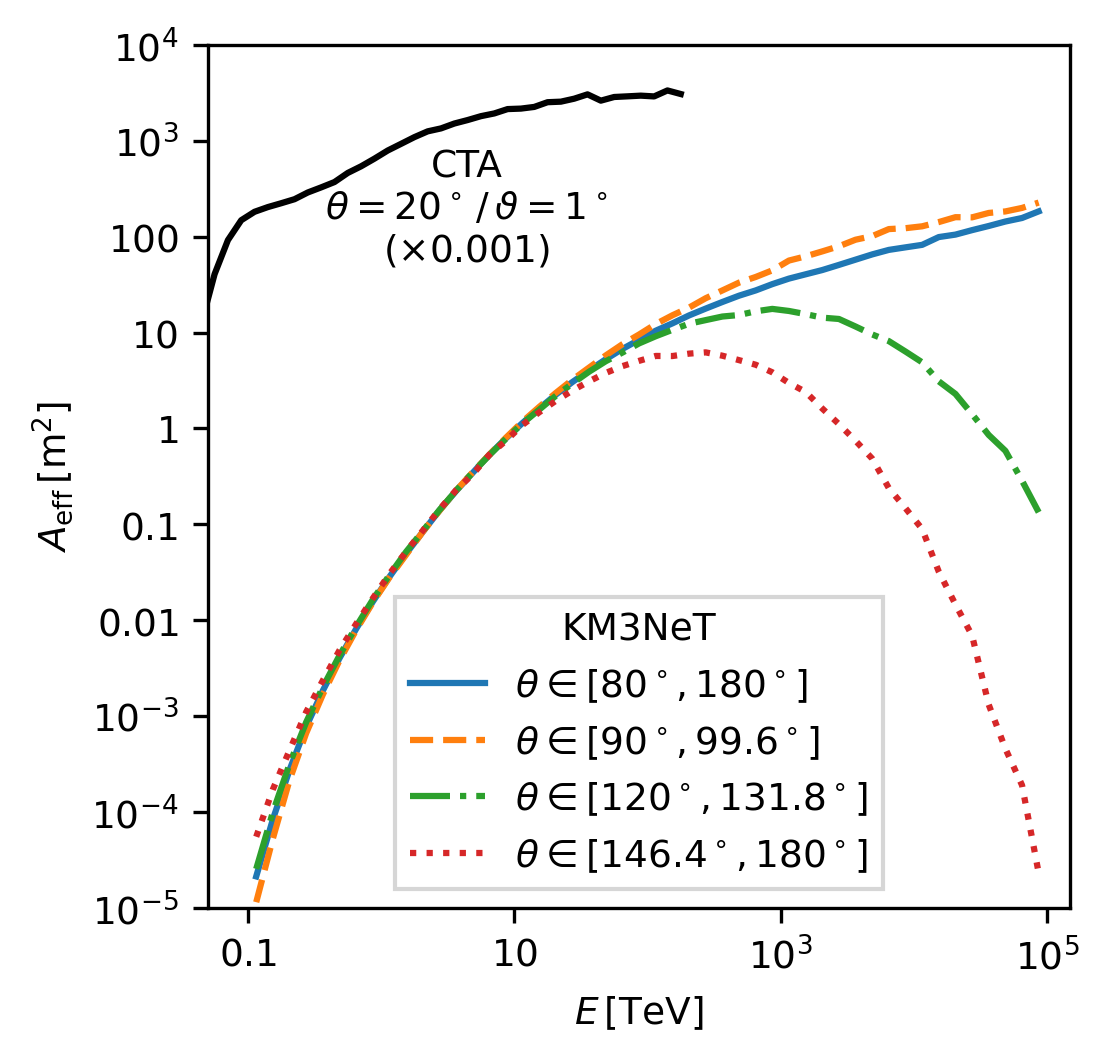

In [7]:
# Paper plot
plot_utils.mpl_settings()
plt.rcParams['font.size'] = 9.0
fig_width = 8.8 / 2.54
ax_width = 0.83
fig_height = 3.4
ax_height = fig_width * ax_width / fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.16, 0.12, ax_width, ax_height])
ax.set_xlabel('$E\,[\mathrm{TeV}]$')
ax.set_ylabel('$A_\mathrm{eff}\,[\mathrm{m}^2]$')

ax.plot(cta_aeff_e, cta_aeff_a/1e3, color='k')

ax.plot(km3_e_binc/1e3, np.mean(km3_aeff[:,5:], axis=1), c='tab:blue',
        label=r'$\theta\in[80^\circ,180^\circ]$')
ax.plot(km3_e_binc/1e3, np.mean(km3_aeff[:,6:8], axis=1), c='tab:orange', ls='--',
        label=r'$\theta\in[90^\circ,99.6^\circ]$')
ax.plot(km3_e_binc/1e3, np.mean(km3_aeff[:,9:11], axis=1), c='tab:green', ls='-.',
        label=r'$\theta\in[120^\circ,131.8^\circ]$')
ax.plot(km3_e_binc/1e3, np.mean(km3_aeff[:,11:], axis=1), c='tab:red', ls=':',
        label=r'$\theta\in[146.4^\circ,180^\circ]$')

ax.legend(title='KM3NeT')
ax.loglog()

ax.text(0.3, 0.88, 'CTA\n'+r'$\theta=20^\circ\,/\,\vartheta=1^\circ$'+'\n'+r'($\times 0.001$)',
        ha='center', va='top', transform=ax.transAxes)

ax.set_xlim(0.05, 1.5e5)
ax.set_xticks([0.1, 10, 1e3, 1e5])
ax.set_ylim(1e-5, 1e4)

ax.set_yticks(np.logspace(-5, 4, 10))

plot_utils.format_log_axis(ax.xaxis)
plot_utils.format_log_axis(ax.yaxis)

if analysisconfig.get_value("write_KM3NeT_IRF_plots", "io"):
    fig.savefig(analysisconfig.get_file("km3net/plots/aeff_cta_km3net.pdf"), dpi=300)

In [16]:
plt.rcdefaults()

## The Point Spread Function (PSF)

In [8]:
km3_psf = PSF3D.read(analysisconfig.get_file("km3net/irfs/psf.fits"))
km3_e1_binc = np.sqrt(km3_psf.energy_hi*km3_psf.energy_lo)*1e3 # in GeV

In [9]:
# We average the PSF in the zenith bins > 90°
psf_value_avg = np.mean(km3_psf.psf_value[:,3:,:], axis=1)
rad_center = (km3_psf.rad_lo + km3_psf.rad_hi)/2 # for interpolation later

# We need to integrate the PSF along the rad axis
sizes_rad_bins = km3_psf.rad_hi.deg**2 - km3_psf.rad_lo.deg**2
rad_drad = np.cumsum(psf_value_avg*(sizes_rad_bins[:,None] * (np.pi/180)**2 * np.pi), axis=0)

In [10]:
### We interpolate the rad values at the corresponding fractions of the integral
km3_psf_cr50=[]
km3_psf_cr68=[]
km3_psf_cr95=[]
for i in range(rad_drad.shape[1]):
    interp_containment = interp1d(rad_drad[:,i], rad_center.deg, assume_sorted=True)
    km3_psf_cr50.append(interp_containment(0.50))
    km3_psf_cr68.append(interp_containment(0.68))
    km3_psf_cr95.append(interp_containment(0.95))

In [11]:
### loading the CTA PSF
cta_psf = cta_irfs['psf']
cta_psf_e = np.logspace(-1, 2.5, 71)*u.TeV
cta_psf_cr50 = cta_psf.containment_radius(cta_psf_e, 1*u.deg, 0.50)[0].to_value('deg')
cta_psf_cr68 = cta_psf.containment_radius(cta_psf_e, 1*u.deg, 0.68)[0].to_value('deg')
cta_psf_cr95 = cta_psf.containment_radius(cta_psf_e, 1*u.deg, 0.95)[0].to_value('deg')

### Directional reconstruction comparison

Comparison of the directional reconstruction accuracy of CTA and KM3NeT. Shown are the median, 68% and 95% containment radii of the PSF as a function of the true γ-ray/neutrino energy. (Fig. 4)

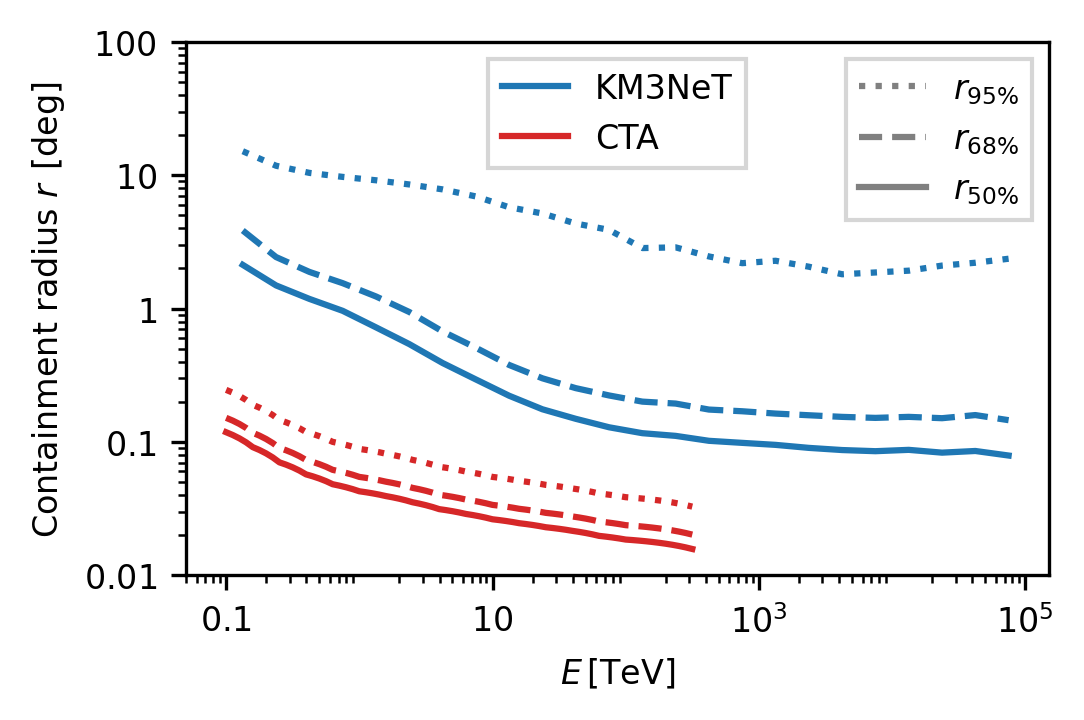

In [24]:
# Paper plot
plot_utils.mpl_settings()
from matplotlib.lines import Line2D

fig_width = 8.8 / 2.54
ax_width = 0.83
fig_height = 2.2
ax_height = fig_width * ax_width / 1.618 / fig_height  # golden ratio

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.16, 0.18, ax_width, ax_height])
ax.set_xlabel('$E\,[\mathrm{TeV}]$')
ax.set_ylabel('Containment radius $r\:\:[\mathrm{deg}]$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(km3_e1_binc/1e3, km3_psf_cr50, color='tab:blue', label='KM3NeT')
ax.plot(km3_e1_binc/1e3, km3_psf_cr68, color='tab:blue', ls='--')
ax.plot(km3_e1_binc/1e3, km3_psf_cr95, color='tab:blue', ls=':')

ax.plot(cta_psf_e, cta_psf_cr50, color='tab:red', label='CTA')
ax.plot(cta_psf_e, cta_psf_cr68, color='tab:red', ls='--')
ax.plot(cta_psf_e, cta_psf_cr95, color='tab:red', ls=':')

leg1 = ax.legend(loc='upper center')
ax.legend([Line2D([0], [0], color='0.5', ls=':'), 
           Line2D([0], [0], color='0.5', ls='--'), 
           Line2D([0], [0], color='0.5')],
          ['$r_{95\%}$', '$r_{68\%}$', '$r_{50\%}$'], loc='upper right')
ax.add_artist(leg1)

ax.set_xlim(0.05, 1.5e5)
ax.set_xticks([0.1, 10, 1e3, 1e5])
ax.set_ylim(0.01, 100)

plot_utils.format_log_axis(ax.xaxis)
plot_utils.format_log_axis(ax.yaxis)

if analysisconfig.get_value("write_KM3NeT_IRF_plots", "io"):
    fig.savefig(analysisconfig.get_file("km3net/plots/psf_cta_km3net.pdf"), dpi=300)

In [16]:
plt.rcdefaults()

## The energy dispersion

In [18]:
edisp_km3net = EnergyDispersion2D.read(analysisconfig.get_file("km3net/irfs/edisp.fits"))

migra_center_km3=np.sqrt(edisp_km3net.data.axes[1].edges[1:]*edisp_km3net.data.axes[1].edges[:-1])
# integrate along the migra axis after averaging over zenith > 90°
mu_dmu_km3 = np.cumsum(np.mean(edisp_km3net.data.data[...,3:], axis=2),axis=1)

In [19]:
### We interpolate the migra values at the corresponding fractions of the integral
km3_edisp_cr50=[]
km3_edisp_cr10=[]
km3_edisp_cr90=[]
for i in range(mu_dmu_km3.shape[0]):
    interp_containment = interp1d(mu_dmu_km3[i,:], migra_center_km3, assume_sorted=True)
    km3_edisp_cr50.append(interp_containment(0.50))
    km3_edisp_cr10.append(interp_containment(0.10))
    km3_edisp_cr90.append(interp_containment(0.90))

In [20]:
edisp_cta = cta_irfs['edisp']

In [21]:
migra_center_cta=edisp_cta.data.axes[1].center
energy_center_cta=edisp_cta.data.axes[0].center
energy_mask_cta = (energy_center_cta<250*u.TeV) & (energy_center_cta>0.1*u.TeV)
mu_dmu_cta = np.cumsum(edisp_cta.data.data[energy_mask_cta,:,1],axis=1)

In [22]:
### We interpolate the migra values at the corresponding fractions of the integral
cta_edisp_cr50=[]
cta_edisp_cr10=[]
cta_edisp_cr90=[]
for i in range(energy_mask_cta.sum()):
    interp_containment = interp1d(mu_dmu_cta[i,:], migra_center_cta, assume_sorted=True)
    cta_edisp_cr50.append(interp_containment(0.50))
    cta_edisp_cr10.append(interp_containment(0.10))
    cta_edisp_cr90.append(interp_containment(0.90))

## Comparison of the energy dispersion

Comparison of the energy reconstruction accuracy of CTA and KM3NeT. Shown are the 10%, 50%, and 90% quantiles of the ratio between the reconstructed and true γ-ray/neutrino energy, as a function of the true energy. (Fig. 5)

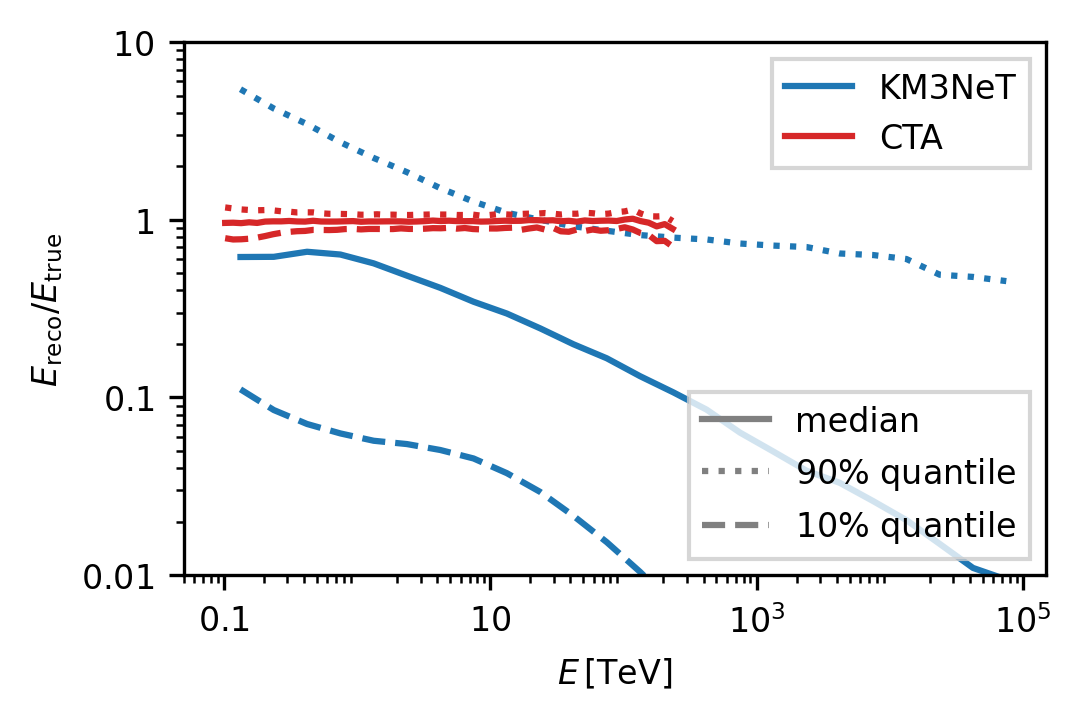

In [38]:
# Paper plot
plot_utils.mpl_settings()

fig_width = 8.8 / 2.54
ax_width = 0.83
fig_height = 2.2
ax_height = fig_width * ax_width / 1.618 / fig_height  # golden ratio

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.16, 0.18, ax_width, ax_height])
ax.set_xlabel('$E\,[\mathrm{TeV}]$')
ax.set_ylabel('$E_\mathrm{reco}/E_\mathrm{true}$')
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(km3_e1_binc/1e3, km3_edisp_cr50, color='tab:blue', label='KM3NeT')
ax.plot(km3_e1_binc/1e3, km3_edisp_cr10, color='tab:blue', ls='--')
ax.plot(km3_e1_binc/1e3, km3_edisp_cr90, color='tab:blue', ls=':')

skip = 3
ax.plot(energy_center_cta[energy_mask_cta][::skip], cta_edisp_cr10[::skip], color='tab:red', ls='--')
ax.plot(energy_center_cta[energy_mask_cta][::skip], cta_edisp_cr50[::skip], color='tab:red', label='CTA')
ax.plot(energy_center_cta[energy_mask_cta][::skip], cta_edisp_cr90[::skip], color='tab:red', ls=':')

leg1 = ax.legend(loc='upper right')
ax.legend([Line2D([0], [0], color='0.5', ls='-'), 
           Line2D([0], [0], color='0.5', ls=':'), 
           Line2D([0], [0], color='0.5', ls='--')],
          ['median', '$90\%$ quantile', '$10\%$ quantile'], loc='lower right')
ax.add_artist(leg1)

ax.set_xlim(0.05, 1.5e5)
ax.set_xticks([0.1, 10, 1e3, 1e5])
ax.set_ylim(0.01, 10)

plot_utils.format_log_axis(ax.xaxis)
plot_utils.format_log_axis(ax.yaxis)

if analysisconfig.get_value("write_KM3NeT_IRF_plots", "io"):
    fig.savefig(analysisconfig.get_file("km3net/plots/edisp_cta_km3net.pdf"), dpi=300)

## The atmospheric neutrino fluxes 

For the atmospheric muon background, a comparison is shown between the interpolated muon distribution and the distribution of the individual muons in the simulation. As the Monte Carlo simulation is not provided here and the IRF files only contain the integrated neutrino background including the prompt and conventional neutrino flux, the raw muon rate and the prompt neutrino rate from the plot are provided separately.

In [33]:
bkg_nu = Background2D.read(analysisconfig.get_file("km3net/irfs/bkg_nu.fits"))
bkg_mu = Background2D.read(analysisconfig.get_file("km3net/irfs/bkg_mu.fits"))
mu_horizon_raw = np.loadtxt(analysisconfig.get_file("km3net/irfs/raw_muon_rate.dat"))[:,1]
atm_prompt_rate = np.loadtxt(analysisconfig.get_file("km3net/irfs/prompt_nu_rate.dat"))[:,1]

In [34]:
t_binc_fine = bkg_nu.data.axes[1].center.to_value('rad')
e_binc_fine_ext = bkg_nu.data.axes[0].center.to_value('GeV')
e_bin_fine_ext = bkg_nu.data.axes[0].edges.to_value('MeV')

de_domega_reco = 4 * np.pi / len(t_binc_fine) * np.diff(e_bin_fine_ext)
t_mask = t_binc_fine * 180 / np.pi > 80  # compute rate for analysis region
t_year = 365 * 24 * 3600

In [35]:
atm_conv_rate = bkg_nu.data.data
mu_horizon_smoothed = bkg_mu.data.data[:,5]

### Background event rates in KM3NeT

The atmospheric neutrino rates are integrated over all zenith angles in the analysis region (θ > 80°). 
The atmospheric muon rate is shown for the zenith angle bin 80°−90° only, since it is completely negligible for larger angles. 
The black line displays the smoothed curve used in the analysis. (Fig. 2)

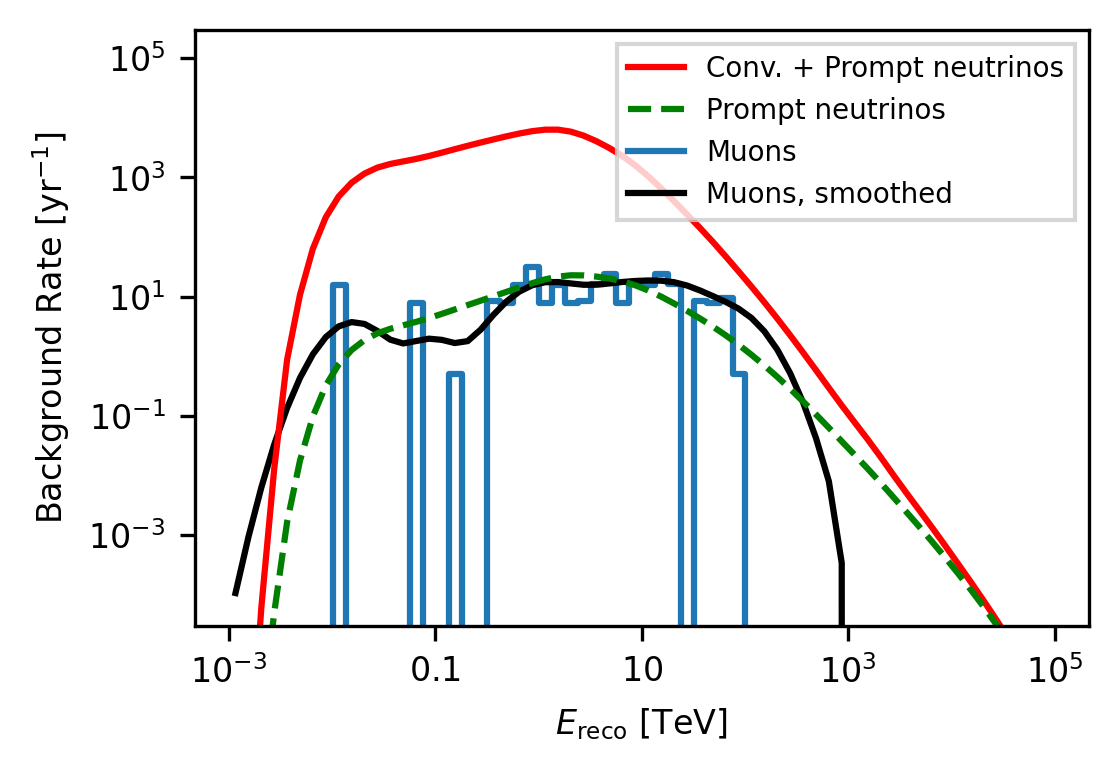

In [36]:
# Paper plot
plot_utils.mpl_settings()
fig_width = 8.8 / 2.54
ax_width = 0.86
fig_height = 2.6
ax_height = fig_width * ax_width / 1.5 / fig_height
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.add_axes([0.13, 0.15, ax_width, ax_height])

ax.plot(e_binc_fine_ext*1e-3, atm_conv_rate[:,t_mask].sum(axis=1) * de_domega_reco * t_year,
        label='Conv. + Prompt neutrinos', c='red')
ax.plot(e_binc_fine_ext*1e-3, atm_prompt_rate * de_domega_reco * t_year,
        label='Prompt neutrinos', c='green', ls='--')
ax.plot(e_binc_fine_ext*1e-3, mu_horizon_raw * de_domega_reco * t_year,
        '-', label='Muons', c='tab:blue', ds='steps-mid', zorder=0)
ax.plot(e_binc_fine_ext*1e-3, mu_horizon_smoothed * de_domega_reco * t_year,zorder=0, c='k',ls='-', label='Muons, smoothed')

ax.loglog()
ax.set_xlabel('$E_\mathrm{reco}$ [TeV]')
ax.set_ylabel('Background Rate [yr$^{-1}$]')
ax.legend(loc='upper right', fontsize='small')
ax.set_ylim(3e-5, 3e5)
ax.set_xticks([10**i for i in range(-3,6,2)])
plot_utils.format_log_axis(ax.xaxis)

if analysisconfig.get_value("write_KM3NeT_IRF_plots", "io"):
    fig.savefig(analysisconfig.get_file("km3net/plots/background_nu_mu_km3net.pdf"), dpi=300)